In [1]:
from scipy.interpolate import griddata
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, BatchNormalization

tf.random.set_seed(42)
from sklearn.model_selection import train_test_split

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2024-01-02 17:36:26.521864: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import pandas as pd
import numpy as np
import plotly.offline as pyo
from plotly import subplots
import plotly.graph_objects as go

np.random.seed(42)

In [ ]:
client = pd.read_csv("../../data/client.csv")
ePrices = pd.read_csv("../../data/electricity_prices.csv")
gasPrices = pd.read_csv("../../data/gas_prices.csv")
train = pd.read_csv("../../data/train.csv")

In [ ]:
weatherPredInt = pd.read_csv("interpolPredWeather.csv")
weatherHistInt = pd.read_csv("../histWeatherSnowCover.csv")

# process data

### merge client & train, add business feat & interpolate daylight savings

In [ ]:
producing = train.loc[train.is_consumption == 0]
consuming = train.loc[train.is_consumption == 1]
train = pd.merge(producing.drop('is_consumption',axis = 1), consuming.drop('is_consumption',axis = 1),on=['data_block_id','prediction_unit_id','datetime','county','is_business','product_type'], how='outer',suffixes=('_prod', '_cons'))
del producing, consuming
print(train.shape)

clientsTime = pd.merge(train, client, on=['county','is_business','product_type','data_block_id'], how='inner')

clientsTime['datetime'] = pd.to_datetime(clientsTime['datetime'])
clientsTime['yearday'] = clientsTime['datetime'].dt.day_of_year
clientsTime['weekday'] = clientsTime['datetime'].dt.day_of_week
clientsTime['month'] = clientsTime['datetime'].dt.month
clientsTime['monthday'] = clientsTime['datetime'].dt.day
clientsTime['year'] = clientsTime['datetime'].dt.year

unique_pairs = list(set(zip(clientsTime['is_business'], clientsTime[ 'product_type'])))
pair_index_dict = {pair: index for index, pair in enumerate(unique_pairs)}
clientsTime['business_prodType'] = list(map(pair_index_dict.get, zip(clientsTime['is_business'], clientsTime['product_type'])))

unique_pairs_cust = list(set(zip(clientsTime['is_business'], clientsTime[ 'product_type'], clientsTime['county'], clientsTime['eic_count'],clientsTime['installed_capacity'])))
pair_index_dict = {pair: index for index, pair in enumerate(unique_pairs_cust)}
clientsTime['ind_customer_id'] = list(map(pair_index_dict.get, zip(clientsTime['is_business'], clientsTime['product_type'], clientsTime['county'], clientsTime['eic_count'],clientsTime['installed_capacity'])))

# interpolate daylight savings
clientsTime = clientsTime.interpolate()

#### get holidays

In [ ]:
import holidays
from datetime import date

us_holidays = holidays.EE()  # this is a dict

clientsTime['holiday'] = clientsTime['datetime'].apply(lambda s : s in us_holidays)

In [ ]:
clientsTime['no_workday'] = ((clientsTime['holiday']) | (clientsTime['weekday'] > 4))

### prepare electric prices

In [ ]:
ePrices.euros_per_mwh.plot()

In [ ]:
ePrices['forecast_date'] = pd.to_datetime(ePrices['forecast_date'])

# Set 'timestamp' as the index
ePrices.set_index('forecast_date', inplace=True)

# Resample to fill missing hours
df_resampled = ePrices.resample('1H').asfreq()

# Linearly interpolate missing values
ePrices = df_resampled.interpolate(method='linear')

In [ ]:
ePrices['euros_per_mwh'] = ePrices.euros_per_mwh.replace(4000.0, np.nan)

# Resample to fill missing hours
df_resampled = ePrices.resample('1H').asfreq()

# Linearly interpolate missing values
ePrices = df_resampled.interpolate(method='linear')

# write data into python arrays

In [ ]:
#clientsTime, weatherPredInt, weatherHistInt, ePrices, gasPrices

featPredWeather = [
        #'latitude', 'longitude', 
        'County', #'forecast_datetime',
       'hours_ahead',
        'data_block_id', #'origin_datetime', 
       'temperatureint',
       'dewpointint', 'cloudcover_highint', 'cloudcover_lowint',
       'cloudcover_midint', 'cloudcover_totalint',
       '10_metre_u_wind_componentint', '10_metre_v_wind_componentint',
       'direct_solar_radiationint', 'surface_solar_radiation_downwardsint',
       'snowfallint', 'total_precipitationint', 
       #'sunrise', 'sunset',
       #'daylight', 'minDaylight'
       ]

predWeatherComplete = weatherPredInt[featPredWeather]
del weatherPredInt

featHistWeather = [
       #'latitude', 'longitude', 
       'County',
       #'datetime', 
       'data_block_id', 
       'temperatureint', 'dewpointint', 'rainint',
       'snowfallint', 'surface_pressureint', 'cloudcover_totalint',
       'cloudcover_lowint', 'cloudcover_midint', 'cloudcover_highint',
       'windspeed_10mint', 'winddirection_10mint', 'shortwave_radiationint',
       'direct_solar_radiationint', 'diffuse_radiationint', 'meltingInCM',
       'snowHeightFlux', 'snowcover'
]
histWeatherComplete = weatherHistInt[featHistWeather]
del weatherHistInt

# can't use client id as an axis in data because it's not constant!
y = np.zeros((clientsTime.shape[0],2))
y_indexes = np.zeros((clientsTime.shape[0],2)) # dataframe indexes in the end, not important for now
index_y = 0

customers = []

constValsArray = np.zeros((1,17))
targetsArray = np.zeros((1,24,2))
ePricesArray = np.zeros((1,24,1))

nFeatHistWeather = histWeatherComplete.shape[1]-1
histWeatherArray = np.zeros((1,24,nFeatHistWeather))
nFeatPredWeather = predWeatherComplete.shape[1]-1
predWeatherArray = np.zeros((1,24,nFeatPredWeather))
dataBlockIdArray = np.zeros((1))

# loop over customer, append all data cycles for each customer
for customerId in clientsTime.ind_customer_id.unique():
    customerSlice = clientsTime.loc[clientsTime.ind_customer_id == customerId]

    for dataBlockId in customerSlice.data_block_id.unique():
        timeSlice = customerSlice.loc[customerSlice.data_block_id == dataBlockId]
        gasSlice = gasPrices.loc[gasPrices.data_block_id == dataBlockId]
        eSlice   = ePrices.loc[ePrices.data_block_id == dataBlockId]

        if len(timeSlice.yearday.unique()) > 1:
            print(timeSlice.yearday.unique())

        # const values
        yearday = timeSlice.yearday.unique()[0]
        weekday = timeSlice.weekday.unique()[0]
        month   = timeSlice.month.unique()[0]
        monthday = timeSlice.monthday.unique()[0]
        year = timeSlice.year.unique()[0]

        holiday = timeSlice.holiday.unique()[0]
        noWorkDay = timeSlice.no_workday.unique()[0]

        county       = customerSlice.county.unique()[0]
        is_business  = customerSlice.is_business.unique()[0]
        product_type = customerSlice.product_type.unique()[0]
        prediction_unit_id = customerSlice.prediction_unit_id.unique()[0] #should be redundant
        eic_count          = customerSlice.eic_count.unique()[0]
        installed_capacity = customerSlice.installed_capacity.unique()[0]
    
        business_prodType = customerSlice.business_prodType.unique()[0]
        ind_customer_id   = customerSlice.ind_customer_id.unique()[0]

        

        lowest_price_per_mwh = gasSlice.lowest_price_per_mwh.iloc[0]
        highest_price_per_mwh = gasSlice.highest_price_per_mwh.iloc[0]
        euros_per_mwh = eSlice['euros_per_mwh'].to_numpy()
        if euros_per_mwh.shape[0] == 23:
            print(dataBlockId, customerId)

        y_cons = timeSlice['target_cons'] / installed_capacity
        y_prod = timeSlice['target_prod'] / installed_capacity

        histWeather = histWeatherComplete.loc[(histWeatherComplete.data_block_id == dataBlockId) & (histWeatherComplete.County == county)]
        predWeather = predWeatherComplete.loc[(predWeatherComplete.data_block_id == dataBlockId) & (predWeatherComplete.County == county)]

        histWeather = histWeather.drop('data_block_id', axis = 1)
        predWeather = predWeather.drop('data_block_id', axis = 1)


        if y_cons.shape[0] == 23:
            print(dataBlockId, customerId)

        new_row = np.array([county, is_business, product_type, prediction_unit_id, eic_count, installed_capacity, 
        business_prodType,ind_customer_id,lowest_price_per_mwh,highest_price_per_mwh,
        yearday,weekday,month,monthday,year,holiday,noWorkDay
        ])
        constValsArray = np.vstack((constValsArray, new_row))

        new_row = np.zeros((1,24,2))
        new_row[:,:,0] = y_cons
        new_row[:,:,1] = y_prod
        targetsArray = np.concatenate((targetsArray, new_row), axis=0)

        new_row = np.zeros((1,24,1))
        new_row[0,:,0] = euros_per_mwh
        ePricesArray = np.concatenate((ePricesArray, new_row), axis=0)

        new_row = np.zeros((1,24,nFeatHistWeather)) #without datablock id
        new_row[:,:,:] = histWeather
        histWeatherArray = np.concatenate((histWeatherArray, new_row), axis=0)

        new_row = np.zeros((1,24,nFeatPredWeather)) # withotu datablock id
        new_row[:,:,:] = predWeather
        predWeatherArray = np.concatenate((predWeatherArray, new_row), axis=0)

        dataBlockIdArray = np.concatenate((dataBlockIdArray, np.array([dataBlockId])))
    


In [ ]:
#remove first rows
targetsArray     = targetsArray[1:,:,:]
constValsArray   = constValsArray[1:,:]
ePricesArray     = ePricesArray[1:,:,:]
histWeatherArray = histWeatherArray[1:,:,:]
predWeatherArray = predWeatherArray[1:,:,:]
dataBlockIdArray = dataBlockIdArray[1:]
print(targetsArray.shape, constValsArray.shape, ePricesArray.shape,histWeatherArray.shape, predWeatherArray.shape, dataBlockIdArray.shape)

In [ ]:
#calc absolute targets, not normalized by capacity
targetsAbs = targetsArray.copy()
targetsAbs = targetsAbs * constValsArray[:,5].reshape(constValsArray.shape[0],1,1)
print(targetsAbs.shape)

In [ ]:
print(targetsArray.shape, constValsArray.shape, ePricesArray.shape,histWeatherArray.shape, predWeatherArray.shape, dataBlockIdArray.shape)

In [ ]:
np.savez('data_arrays_snowcover_holidays.npz', arr1=targetsArray, arr2=constValsArray, arr3=ePricesArray, arr4 = histWeatherArray, arr5=predWeatherArray, arr6=dataBlockIdArray, arr7=targetsAbs)

# load data & preselect data

In [136]:
loaded_data = np.load('data_arrays_absTarget_oldTarget.npz')

# Access individual arrays by their keys
targetsAbs = loaded_data['arr1']
constValsArray = loaded_data['arr2']
ePricesArray = loaded_data['arr3']
histWeatherArray = loaded_data['arr4']
predWeatherArray = loaded_data['arr5']
dataBlockIdArray = loaded_data['arr6']
oldTargetsAbs = loaded_data['arr7']


featPredWeather = [
        'County',
       'hours_ahead',
       # 'data_block_id',
       'temperatureint',
       'dewpointint', 'cloudcover_highint', 'cloudcover_lowint',
       'cloudcover_midint', 
       'cloudcover_totalint',
       '10_metre_u_wind_componentint', '10_metre_v_wind_componentint',
       'direct_solar_radiationint', 'surface_solar_radiation_downwardsint',
       'snowfallint', 'total_precipitationint', 
       ]

#correct hours
predWeatherArray[:,:,1] = predWeatherArray[:,:,1] - 24

# add sin of hours
sinDay = np.reshape(np.sin((2*predWeatherArray[:,:,1] - 24)*np.pi/24),(predWeatherArray.shape[0],predWeatherArray.shape[1],1))
predWeatherArray = np.concatenate((predWeatherArray, sinDay), axis=2)
featPredWeather = featPredWeather + ['sinDay']

cosDay = np.reshape(np.cos((2*predWeatherArray[:,:,1] - 24)*np.pi/24),(predWeatherArray.shape[0],predWeatherArray.shape[1],1))
predWeatherArray = np.concatenate((predWeatherArray, cosDay), axis=2)
featPredWeather = featPredWeather + ['cosDay']
nPredFeat = predWeatherArray.shape[2]


featConst =['county', 'is_business', 'product_type', 'prediction_unit_id', 'eic_count', 'installed_capacity', 'business_prodType', 'ind_customer_id',
'lowest_price_per_mwh','highest_price_per_mwh','yearday','weekday','month','monthday','year','holiday','no_workday'
]



# add sin of year day
yeardayIdx = 10
CapIdx = 5
sinYear = np.reshape(np.sin(2*constValsArray[:,yeardayIdx]*np.pi/365),(constValsArray.shape[0],1))
constValsArray = np.concatenate((constValsArray, sinYear), axis=1)
featConst = featConst + ['sinYearDay']

cosYear = np.reshape(np.cos(2*constValsArray[:,yeardayIdx]*np.pi/365),(constValsArray.shape[0],1))
constValsArray = np.concatenate((constValsArray, cosYear), axis=1)
featConst = featConst + ['cosYearDay']

nConst = constValsArray.shape[1]



featHistWeather = [
       'County', 
       #'data_block_id', 
       'temperatureint', 'dewpointint', 'rainint',
       'snowfallint', 'surface_pressureint', 'cloudcover_totalint',
       'cloudcover_lowint', 'cloudcover_midint', 'cloudcover_highint',
       'windspeed_10mint', 'winddirection_10mint', 'shortwave_radiationint',
       'direct_solar_radiationint', 'diffuse_radiationint', 'meltingInCM',
       'snowHeightFlux', 'snowcover'
]
#featHistWeatherKeepIdx = [1,10]
#histWeatherArray=histWeatherArray[:,:,featHistWeatherKeepIdx]

#featHistWeather = [featHistWeather[i] for i in featHistWeatherKeepIdx]
nHistFeat = histWeatherArray.shape[2]

print(nPredFeat,nHistFeat,nConst)

16 18 19


In [137]:
#4,5,6,7,10,11,12
featPredWeatherKeepIdx = [1,2,14,15, 4,5,6,7,10,11,12] #only keep cos/sin day features
predWeatherArray=predWeatherArray[:,:,featPredWeatherKeepIdx]
featPredWeather = [featPredWeather[i] for i in featPredWeatherKeepIdx]
nPredFeat = predWeatherArray.shape[2]

#3,4 (prediction unit id, eic count)
#7 ind cust id
# 10 yearday
# 13 monthday
# 14 year
# 15 holiday
featConstKeepIdx = [0,1,2,5,6,8,9,10,11,12,16,17,18]
constValsArray=constValsArray[:,featConstKeepIdx]
featConst = [featConst[i] for i in featConstKeepIdx]
nConst = constValsArray.shape[1]
yeardayIdx = featConstKeepIdx.index(10)
busProdTypeIdx = featConstKeepIdx.index(6)
CapIdx = featConstKeepIdx.index(5)

featHistWeatherKeepIdx = [1,17]
histWeatherArray=histWeatherArray[:,:,featHistWeatherKeepIdx]
featHistWeather = [featHistWeather[i] for i in featHistWeatherKeepIdx]
nHistFeat = histWeatherArray.shape[2]
print(nPredFeat,nHistFeat,nConst)

11 2 13


# build a model & train it

#### split data based on time

In [138]:
trainSplit = int(max(dataBlockIdArray)*0.6)
mask = dataBlockIdArray < trainSplit

In [139]:
shuffledArr = [constValsArray,ePricesArray,histWeatherArray,predWeatherArray,targetsAbs,dataBlockIdArray]

X_train = [shuffledArr[0][mask],shuffledArr[1][mask],shuffledArr[2][mask],shuffledArr[3][mask]]
# only const and e prices
#X_train = [shuffledArr[0][mask],shuffledArr[1][mask],shuffledArr[3][mask]]
y_trainAbs = shuffledArr[4][mask]

X_test = [shuffledArr[0][~mask],shuffledArr[1][~mask],shuffledArr[2][~mask],shuffledArr[3][~mask]]
y_testAbs = shuffledArr[4][~mask]

#### shuffle training data

In [141]:

index_array = np.arange(X_train[0].shape[0])
if 1: #not shuffle!!
    np.random.shuffle(index_array)

arrays = [X_train[0],X_train[1],X_train[2],X_train[3],y_trainAbs]
[X_train[0],X_train[1],X_train[2],X_train[3],y_trainAbs] = [arr[index_array] for arr in arrays]
del arrays

#### calculate class weights

In [149]:
from sklearn.utils.class_weight import compute_sample_weight

# Calculate class weights
class_weights = compute_sample_weight(class_weight='balanced', y=X_train[0][:,[busProdTypeIdx]]) #y_train[:,:,0]) #, X=[X_train[0][:,[yeardayIdx,5,6]]])

class_weight_dict = dict(enumerate(class_weights))

In [ ]:
# calculate sample weight based on target bins
targets = []
for i in range(0,y_train.shape[0]):
    targets.append(np.sum(y_train[i,:,0]))

classWeightDf = pd.DataFrame()
classWeightDf['y_consSum'] = targets

bins = np.linspace(0, classWeightDf['y_consSum'].max(), 26)
classWeightDf['bin'] = pd.cut(classWeightDf['y_consSum'], bins=bins)

frequencies = classWeightDf['bin'].value_counts().to_dict()
classWeightDf['sample_weights'] = classWeightDf['bin'].apply(lambda val: 1 / frequencies[val] if frequencies[val] >0 else 0)
classWeightDf['sample_weights'] = classWeightDf['sample_weights'] / classWeightDf['sample_weights'].mean()
print(classWeightDf.loc[classWeightDf['sample_weights'].isna()],
    classWeightDf.loc[classWeightDf['sample_weights']<= 0.0])

class_weight_dict = dict(enumerate(classWeightDf['sample_weights']))

### define model & train it

### use a feed forward model for production and consumption separately

In [150]:
weatherPred_inputs2 = tf.keras.Input(shape=(24, nPredFeat), name='weatherPred_inputs2')
ePrices_inputs2 = tf.keras.Input(shape=(24, 1), name='ePrices_inputs2')
weatherHist_input2 = tf.keras.Input(shape=(24, nHistFeat), name='weatherHist_input2')
constant_inputs2 = tf.keras.Input(shape=(nConst,), name='constant_inputs2')

weatherPred_inputs2_normalized = BatchNormalization()(weatherPred_inputs2)
ePrices_inputs2_normalized = BatchNormalization()(ePrices_inputs2)
weatherHist_input2_normalized = BatchNormalization()(weatherHist_input2)
constant_inputs2_normalized = BatchNormalization()(constant_inputs2)


if 0:
    weatherPred_flattened2 = layers.Flatten()(weatherPred_inputs2_normalized)
    for i in range(0,3):
        weatherPred_flattened2 = layers.Dense(24*nPredFeat, activation='relu')(weatherPred_flattened2)
        #weatherPred_flattened2 = layers.Dropout(0.1)(weatherPred_flattened2)
    weatherHist_flattened2 = layers.Flatten()(weatherHist_input2_normalized)
    for i in range(0,3):
        weatherHist_flattened2 = layers.Dense(24*nHistFeat, activation='relu')(weatherHist_flattened2)
        #weatherHist_flattened2 = layers.Dropout(0.1)(weatherHist_flattened2)
    
    ePrices_layer2 = layers.Flatten()(ePrices_inputs2_normalized)
    for i in range(0,1):
        ePrices_layer2 = layers.Dense(24, activation='relu')(ePrices_layer2)
        #ePrices_layer2 = layers.Dropout(0.1)(ePrices_layer2)

    constInp_layer2 = layers.Dense(nConst, activation='relu')(constant_inputs2_normalized)
    for i in range(0,0):
        constInp_layer2 = layers.Dense(16, activation='relu')(constInp_layer2)

    
    x2 = layers.Concatenate()([ePrices_layer2,weatherPred_flattened2,weatherHist_flattened2,constInp_layer2])
    for i in range(0,2):
        x2 = layers.Dense(int(x2.shape[-1]*(i+1)), activation='relu')(x2)
        print(x2.shape)
    for i in range(0,2):
        x2 = layers.Dense(int(x2.shape[-1]/(i+2)), activation='relu')(x2)
        print(x2.shape)
    y1 = layers.Dense(int(x2.shape[-1]/(i+2)), activation='relu')(x2)
    y2 = layers.Dense(int(x2.shape[-1]/(i+2)), activation='relu')(x2)

    output_layer01 = tf.expand_dims(layers.Dense(24, activation='relu', name='output01')(y1), axis = -1)
    output_layer02 = tf.expand_dims(layers.Dense(24, activation='relu', name='output02')(y2), axis = -1)
    output_layer2 = tf.concat([output_layer01,output_layer02], axis = -1)
# somehow logical model
if 1:
    #x2 = layers.Concatenate()([constInp_layer2]) #ePrices_layer2
    constInp_layer2 = layers.Dense(nConst, activation='relu')(constant_inputs2_normalized)
    constInp_layer2 = layers.Dense(nConst, activation='relu')(constInp_layer2)
    #constInp_layer2 = layers.Dense(1, activation='relu')(constInp_layer2)
    #constInp_layer2 = layers.Dense(16, activation='relu')(constInp_layer2)


    weatherPred_flattened2 = layers.Flatten()(weatherPred_inputs2_normalized)
    weatherHist_flattened2 = layers.Flatten()(weatherHist_input2_normalized)
    ePrices_layer2 = layers.Flatten()(ePrices_inputs2_normalized)

    x = layers.Concatenate()([ePrices_layer2,weatherPred_flattened2,weatherHist_flattened2])
    for i in range(0,3):
        x  = layers.Dense(int(x.shape[1]), activation='relu')(x)
        print(x.shape)
    for i in range(0,3):
        x  = layers.Dense(int(x.shape[1]/(i+1)), activation='relu')(x)
        print(x.shape)
    trendi = layers.Dense(24, activation='relu')(x)
    
    y = []
    for i in range(0,24):
        weatherPred_flattened2 = weatherPred_inputs2_normalized[:,i,:]
        weatherHist_flattened2 = weatherHist_input2_normalized[:,i,:]
        ePrices_layer2         = ePrices_inputs2_normalized[:,i,:]
        #print(weatherPred_flattened2.shape,weatherHist_flattened2.shape, ePrices_layer2.shape)
        x1 = layers.Concatenate()([weatherPred_flattened2, ePrices_layer2,weatherHist_flattened2, tf.expand_dims(trendi[:,i],axis=-1)])
        for i in range(0,2):
            x1 = layers.Dense(x1.shape[-1], activation='relu')(x1)
        x2 = layers.Concatenate()([x1, constInp_layer2])

        for i in range(0,2):
            x2 = layers.Dense(x2.shape[-1], activation='relu')(x2) #making it bigger helps a bit, but not super significant
            #print(x2.shape)
        #x2 = layers.Dense(int(x2.shape[-1]/2), activation='relu')(x2)

        x2 = layers.Dense(2, activation='relu')(x2)
        y.append(x2)
        #x = layers.Dropout(0.1)(x)
    output_layer2 = tf.stack(y,axis =1)
    print(output_layer2.shape)
    #output_layer2 = layers.Reshape((24, 2))(output_layer2)

model3 = tf.keras.Model(inputs=[constant_inputs2,ePrices_inputs2, weatherHist_input2, weatherPred_inputs2], outputs=output_layer2)


def absolute_loss(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_true - y_pred))


model3.compile(optimizer='adam', loss='mae')#, metrics=custom_metric)#absolute_loss, metrics=['mae'])
# 0 = cons, 1 = prod
history3 = model3.fit(X_train, y_trainAbs, validation_data=(X_test, y_testAbs), epochs=100, batch_size=5000, sample_weight=class_weights)

(None, 336)
(None, 336)
(None, 336)
(None, 336)
(None, 168)
(None, 56)
(None, 24, 2)
Epoch 1/100
5/5 [==============================] - 8s 599ms/step - loss: 178.8458 - val_loss: 310.2441
Epoch 2/100
5/5 [==============================] - 1s 224ms/step - loss: 178.3696 - val_loss: 308.3254
Epoch 3/100
5/5 [==============================] - 1s 201ms/step - loss: 177.0466 - val_loss: 305.7344
Epoch 4/100
5/5 [==============================] - 1s 199ms/step - loss: 175.8256 - val_loss: 304.1553
Epoch 5/100
5/5 [==============================] - 1s 205ms/step - loss: 174.8103 - val_loss: 301.9741
Epoch 6/100
5/5 [==============================] - 1s 211ms/step - loss: 174.3436 - val_loss: 302.2465
Epoch 7/100
5/5 [==============================] - 1s 205ms/step - loss: 173.9044 - val_loss: 300.7805
Epoch 8/100
5/5 [==============================] - 1s 206ms/step - loss: 173.4404 - val_loss: 300.7356
Epoch 9/100
5/5 [==============================] - 1s 210ms/step - loss: 173.0309 - val_los

In [146]:
#model3.optimizer.lr.assign(0.05)  # Set a new learning rate for subsequent calls to fit
history3 = model3.fit(X_train, y_trainAbs, validation_data=(X_test, y_testAbs), epochs=100, batch_size=40000, sample_weight=class_weights)

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 48.4400 - val_loss: 102.0114
Epoch 2/100
1/1 [==============================] - 1s 1s/step - loss: 48.3493 - val_loss: 101.5223
Epoch 3/100
1/1 [==============================] - 1s 1s/step - loss: 48.1162 - val_loss: 100.7983
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 47.8376 - val_loss: 99.9808
Epoch 5/100
1/1 [==============================] - 2s 2s/step - loss: 47.6217 - val_loss: 99.1910
Epoch 6/100
1/1 [==============================] - 2s 2s/step - loss: 47.5179 - val_loss: 98.5122
Epoch 7/100
1/1 [==============================] - 2s 2s/step - loss: 47.4988 - val_loss: 97.9834
Epoch 8/100
1/1 [==============================] - 2s 2s/step - loss: 47.4872 - val_loss: 97.6117
Epoch 9/100
1/1 [==============================] - 2s 2s/step - loss: 47.4198 - val_loss: 97.3844
Epoch 10/100
1/1 [==============================] - 1s 1s/step - loss: 47.2843 - val_loss: 97.2907
Epoch 11/100
1/1

In [147]:
fig = go.Figure()
length = len(history3.history['loss'])
fig.add_trace(go.Scatter(x=np.arange(1, length+1), y=history3.history['loss'], mode='lines', name='Train Loss'))
fig.add_trace(go.Scatter(x=np.arange(1, length+1), y=history3.history['val_loss'], mode='lines', name='Validation Loss'))
fig.update_layout(
    title='Training and Validation Loss Over Epochs',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    legend=dict(x=0, y=1, traceorder='normal'),
)
fig.show()

In [20]:
a = model3.predict(X_test)
predVals = a*X_test[0][:,CapIdx].reshape(X_test[0].shape[0],1)
print(np.mean(np.abs(y_testAbs[:,:,0] - predVals)))
a = model3.predict(X_train)
predVals = a*X_train[0][:,CapIdx].reshape(X_train[0].shape[0],1)
trueVals = targetsAbs[0:trainSplit,:]
print(np.mean(np.abs(y_trainAbs[:,:,0]  - predVals)))
del a,predVals,trueVals

#flatten out all input
#38/101 (fully connected predict 48 vals)
# 16/110 (last layer separates)
# 45/97 (more layers for separation)

# somewhat logical structure
# 44/82 -> 40/80


# mean cons error single traines =35-37 (train) 53-57 (test) -> 34/63 -> 32/55
# mean prod error single trainer = 9-20 -> 10/18

401/401 [==============================] - 1s 3ms/step
682.7754489150414
908/908 [==============================] - 2s 2ms/step
412.0196809557261


In [148]:
#model2.save('prod_model_.h5')
model3.save('model_dual_pred.h5')

### transformer net
maximum around 140 test error

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Flatten,Reshape
from tensorflow.keras.models import Model


# Encoder
weatherPred_inputs3 = tf.keras.Input(shape=(24, nPredFeat), name='weatherPred_inputs2')
ePrices_inputs3 = tf.keras.Input(shape=(24, 1), name='ePrices_inputs2')
#weatherHist_input2 = tf.keras.Input(shape=(24, 2), name='weatherHist_input2')
constant_inputs3 = tf.keras.Input(shape=(nConst,), name='constant_inputs2')
weatherPred_inputs3_normalized = BatchNormalization()(weatherPred_inputs3)
ePrices_inputs3_normalized = BatchNormalization()(ePrices_inputs3)
#weatherHist_input2_normalized = BatchNormalization()(weatherHist_input2)
constant_inputs3_normalized = BatchNormalization()(constant_inputs3)

encoder_inputs = tf.concat([weatherPred_inputs3_normalized, ePrices_inputs3_normalized], axis=-1)
#Input(shape=(24,num_transformer_blocks), name="encoder_inputs")

attention_outputs = []
for i in range(encoder_inputs.shape[-1]):
    x = encoder_inputs[:, :, i]
    x = Reshape((-1, 1))(x)
    y = x
    x = MultiHeadAttention(num_heads=4, key_dim=8, value_dim=24)(x, x)
    #print(x.shape)
    #x = Dense(24, activation="relu")(x)
    #x = Dense(32, activation="softmax")(x)
    #x = LayerNormalization(epsilon=1e-6)(x)
    x = tf.keras.layers.Add()([x, y])
    #x = LayerNormalization(epsilon=1e-6)(x)
    x = Dense(24, activation="relu")(x)
    #x = Dense(1, activation="relu")(x)
    attention_outputs.append(x)

y = tf.concat(attention_outputs, axis=-1)
#x = LayerNormalization(epsilon=1e-6)(x)
y = Dense(144, activation="relu")(y)
#y = LayerNormalization(epsilon=1e-6)(y)
y = Dense(128, activation="relu")(y)
y = Dense(128, activation="relu")(y)
y = Dense(128, activation="relu")(y)
#y = Dense(24, activation="relu")(y)
#y = Dense(24, activation="relu")(y)
#y = Dense(24, activation="relu")(y)

#y = tf.keras.layers.Add()([x, y])  # Residual connection

# Flatten the encoder output
encoder_outputs = Flatten()(y)

print(encoder_outputs)
# Concatenate encoder and decoder outputs
concatenated_outputs = tf.concat([encoder_outputs, constant_inputs3_normalized],axis=-1)

# Multi-layer perceptron (MLP) for final prediction
#concatenated_outputs = Dense(256, activation='relu')(concatenated_outputs)
concatenated_outputs = Dense(128, activation='relu')(concatenated_outputs)
for _ in range(10):
    concatenated_outputs = Dense(128, activation='relu')(concatenated_outputs)
final_output = Dense(24, activation="linear")(concatenated_outputs)

# Build the model
transformer_model = Model(inputs=[constant_inputs3, ePrices_inputs3, weatherPred_inputs3], outputs=final_output)

# Compile the model
transformer_model.compile(optimizer='adam', loss='mae')

history3 = transformer_model.fit(X_train, y_trainAbs[:,:,0], validation_data=(X_test, y_testAbs[:,:,0]), epochs=20, batch_size=250, class_weight=class_weight_dict)


In [ ]:
transformer_model.save('transformer1.h5')

In [ ]:
fig = go.Figure()
length = len(history3.history['loss'])
fig.add_trace(go.Scatter(x=np.arange(1, length+1), y=history3.history['loss'], mode='lines', name='Train Loss'))
fig.add_trace(go.Scatter(x=np.arange(1, length+1), y=history3.history['val_loss'], mode='lines', name='Validation Loss'))
fig.update_layout(
    title='Training and Validation Loss Over Epochs',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    legend=dict(x=0, y=1, traceorder='normal'),
)
fig.show()

# reconstruct dataframe and analyse results

In [32]:
# restructure dataframes, SHOULD BE CONST IF WE DON'T CHANGE MASK & NOT SHUFFLE
storedArr = shuffledArr
#storedArr[0]=storedArr[0][:,featConstKeepIdx]

appendedList = []
shuffledDataBlockId = storedArr[5]
for i,data_block_id in enumerate(shuffledDataBlockId):
    isTrain = mask[i]
    
    new_columns = np.zeros((24, 2))  # Adjust the size according to your requirements

    #use targets as first block
    dataBlock = storedArr[4][i,:,:].reshape(24,2)

    #add train/test info & data block id
    new_columns = np.ones((24, 2)) * [isTrain, data_block_id]
    dataBlock = np.hstack((dataBlock, new_columns))
    #add const values
    new_columns = np.ones((24, storedArr[0].shape[1])) * storedArr[0][i,:].reshape(1,storedArr[0].shape[1])
    dataBlock = np.hstack((dataBlock, new_columns))
    #eprices (of yesterday)
    dataBlock = np.hstack((dataBlock, storedArr[1][i,:,:].reshape(24,1)))
    # add weather prediction
    dataBlock = np.hstack((dataBlock, storedArr[3][i,:,:].reshape(24,storedArr[3].shape[2])))
    # hist weather
    dataBlock = np.hstack((dataBlock, storedArr[2][i,:,:].reshape(24,storedArr[2].shape[2])))

    #hist weather, flatten the array and add all values as columns
    #new_columns = np.ones((24, 100)) * shuffledArr[2][i,:].reshape(1,100)
    #dataBlock = np.hstack((dataBlock, new_columns))

    appendedList.append(dataBlock)
featPredWeather2 = []
for f in featPredWeather:
    featPredWeather2.append(f+str('_pred'))


feat = ['y_cons','y_prod','isTrain','data_block_id'] + featConst + ['ePrices'] + featPredWeather2 + featHistWeather
#for i in range(0,10):
#    feat = feat + [f'{value}_'+str(i) for value in featHistWeather]

appendedDf = pd.DataFrame(np.vstack(appendedList), columns=feat)

from datetime import datetime, timedelta
appendedDf['unique_time'] = appendedDf.apply(lambda row: datetime(row['year'].astype(int), 1, 1) + timedelta(days=row['yearday'] - 1, hours=row['hours_ahead_pred']-24), axis=1)
#appendedDf['unique_time'] = appendedDf.apply(lambda row: datetime(2022, 1, 1) + timedelta(days=row['yearday'] - 1, hours=row['hours_ahead']-24), axis=1)
    
            

In [33]:
#4,5,6,7,10,11,12
featPredWeatherKeepIdx1 = [1,2,14,15, 4,5,6,7,10,11,12] #only keep cos/sin day features
storedArr[3]=storedArr[3][:,:,featPredWeatherKeepIdx1]

#3,4 (prediction unit id, eic count)
#7 ind cust id
# 10 yearday
# 13 monthday
# 14 year
# 15 holiday
featConstKeepIdx1 = [0,1,2,5,6,8,9,10,11,12,16,17,18]
storedArr[0]=storedArr[0][:,featConstKeepIdx1]

featHistWeatherKeepIdx1 = [1,17]
storedArr[2]=storedArr[2][:,:,featHistWeatherKeepIdx1]

In [113]:
X2 = [storedArr[0],storedArr[1],storedArr[2],storedArr[3]]
#X2 = [storedArr[0],storedArr[1],storedArr[3]]
#X2[0]  = scaler0.transform(X2[0])
pred = model3.predict(X2)

#pred_cons = pred_cons*X2[0][:,CapIdx].reshape(X2[0].shape[0],1)
#pred_cons = scalerT.inverse_transform(pred_cons.reshape(-1,1)).reshape(-1,24,1)

appendedListProd = []
appendedListCons = []
for i in range(0,pred.shape[0]):
    appendedListCons.append(pred[i,:,0].reshape(24,1))
    appendedListProd.append(pred[i,:,1].reshape(24,1))

appendedDf['pred_cons'] = np.vstack(appendedListCons)    
appendedDf['pred_prod'] = np.vstack(appendedListProd)

appendedDf['absErr_cons'] = (appendedDf['y_cons']-appendedDf['pred_cons'])
appendedDf['absErr_prod'] = (appendedDf['y_prod']-appendedDf['pred_cons'])
print(X2[0].shape)



1309/1309 [==============================] - 5s 3ms/step
(41869, 13)


# analyze dataframe
good generalization, test and train are pretty much always the same

production:
- overweighting big producers -> lots of errors for smaller capacities

consumption:
- bigger error in summer


In [114]:
trainDf = appendedDf.loc[appendedDf.isTrain == True]
testDf = appendedDf.loc[appendedDf.isTrain == False]

# investigate consumption target

In [133]:
appendedDf.columns

Index(['y_cons', 'y_prod', 'isTrain', 'data_block_id', 'county', 'is_business',
       'product_type', 'prediction_unit_id', 'eic_count', 'installed_capacity',
       'business_prodType', 'ind_customer_id', 'lowest_price_per_mwh',
       'highest_price_per_mwh', 'yearday', 'weekday', 'month', 'monthday',
       'year', 'holiday', 'no_workday', 'sinYearDay', 'cosYearDay', 'ePrices',
       'County_pred', 'hours_ahead_pred', 'temperatureint_pred',
       'dewpointint_pred', 'cloudcover_highint_pred', 'cloudcover_lowint_pred',
       'cloudcover_midint_pred', 'cloudcover_totalint_pred',
       '10_metre_u_wind_componentint_pred',
       '10_metre_v_wind_componentint_pred', 'direct_solar_radiationint_pred',
       'surface_solar_radiation_downwardsint_pred', 'snowfallint_pred',
       'total_precipitationint_pred', 'sinDay_pred', 'cosDay_pred', 'County',
       'temperatureint', 'dewpointint', 'rainint', 'snowfallint',
       'surface_pressureint', 'cloudcover_totalint', 'cloudcover_lowint

In [157]:
appendedDf['ind_customer_id2'] = appendedDf.groupby(['county', 'is_business','product_type','business_prodType']).ngroup() + 1 #,'eic_count'
appendedDf['combinedTarg'] = appendedDf['y_cons'] + appendedDf['y_prod']

# maybe the consumption at night == base & during day it's lower when we have solar power!!
# consumption 
appendedDf['value_changed_eic'] = appendedDf['eic_count'] != appendedDf['eic_count'].shift(1)
appendedDf['value_changed_cap'] = appendedDf['installed_capacity'] != appendedDf['installed_capacity'].shift(1)

In [189]:
appendedDf.loc[appendedDf.product_type == 2]['y_prod'].mean()

5.519197481776011

consumption depends on:
- production
- hour
- year
- temperature!! long term trend very much connected to temperature
    - for business it might be that different customers are more significant -> split into customers needed

production:
- installed capacity
- solar radiation

General:
- combined consumption & production is important
- if production higher -> consumption lower
- "Grundumsatz" more or less similar between nights, but influenced by temperatures over the year!!

USUALLY peaks around 8:00 & 19:00, bottom around 15:00 & 1:00 (night is lower)
with solar power, bottom is at 12! (solar peak at 12)

eic count & capacity change at the same time! (only 7 excemptions) -> 90% false positives from calculation

In [193]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

pd.set_option('Display.max_columns',None)
a = appendedDf.loc[(appendedDf.ind_customer_id2 == 7)]# & (appendedDf.hours_ahead_pred == 0)]#.groupby('yearday').min()#['y_cons']#
#a = appendedDf.loc[appendedDf.data_block_id == 124]
print('business',a.is_business.unique(),'prodType', a.product_type.unique(),'county',a.county.unique())
fig = make_subplots(rows=3,cols=1)
#for data_block_id in a.data_block_id.unique():
#    a_sub = a.loc[a.data_block_id == data_block_id]
#    fig.add_trace(go.Scatter(x=a_sub.hours_ahead_pred, y=a_sub.y_cons, mode='lines', name='y_cons', legendgroup=data_block_id),row=1,col=1)
#    fig.add_trace(go.Scatter(x=a_sub.hours_ahead_pred, y=a_sub.y_prod, mode='lines', name='y_prod', legendgroup=data_block_id),row=2,col=1)
#    fig.add_trace(go.Scatter(x=a_sub.hours_ahead_pred, y=a_sub.combinedTarg, mode='lines', name='y_prod', legendgroup=data_block_id),row=3,col=1)#

#fig.show()

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=a.unique_time, y=a.y_cons, mode='lines', name='y_cons'))
fig2.add_trace(go.Scatter(x=a.unique_time, y=a.y_prod, mode='lines', name='y_prod'))
fig2.add_trace(go.Scatter(x=a.unique_time, y=a.combinedTarg, mode='lines', name='comb'))
fig2.add_trace(go.Scatter(x=a.unique_time, y=a.temperatureint*100, mode='lines', name='temp'))
fig2.add_trace(go.Scatter(x=a.unique_time, y=a.installed_capacity, mode='lines', name='cap'))
#fig2.add_trace(go.Scatter(x=a.unique_time, y=a.lowest_price_per_mwh, mode='lines', name='lowest_price_per_mwh'))
#fig2.add_trace(go.Scatter(x=a.unique_time, y=a.highest_price_per_mwh, mode='lines', name='highest_price_per_mwh'))
#fig2.add_trace(go.Scatter(x=a.unique_time, y=a.ePrices, mode='lines', name='ePrices'))
fig2.show()

business [1.] prodType [3.] county [0.]


In [115]:
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=a.unique_time, y=a.y_cons, mode='lines', name='y_cons'))
fig2.add_trace(go.Scatter(x=a.unique_time, y=a.y_prod, mode='lines', name='y_prod'))
fig2.add_trace(go.Scatter(x=a.unique_time, y=a.combinedTarg, mode='lines', name='comb'))
fig2.show()

/Users/matthiaskargl/opt/anaconda3/envs/predictenegycons/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [98]:
a.loc[a.hours_ahead == 8]

y_cons  y_prod  isTrain  data_block_id  county  is_business  \
239120  5688.884   0.002      1.0          124.0    11.0          1.0   
239144  6485.259   0.000      1.0          125.0    11.0          1.0   
239168  6588.234   0.005      1.0          126.0    11.0          1.0   
239192  6673.206   0.010      1.0          127.0    11.0          1.0   
239216  6571.488   0.001      1.0          128.0    11.0          1.0   
239240  3758.523   0.000      1.0          129.0    11.0          1.0   
239264  3145.923   0.000      1.0          130.0    11.0          1.0   
239288  6565.505   0.000      1.0          131.0    11.0          1.0   
239312  6766.200   0.000      1.0          132.0    11.0          1.0   

        product_type  prediction_unit_id  eic_count  installed_capacity  \
239120           3.0                48.0      118.0              5803.9   
239144           3.0                48.0      118.0              5803.9   
239168           3.0                48.0      118.0              5803.9   
239192           3.0                48.0      118.0              5803.9   
239216           3.0                48.0      118.0              5803.9   
239240           3.0                48.0      118.0              5803.9   
239264           3.0                48.0      118.0              5803.9   
239288           3.0                48.0      118.0              5803.9   
239312           3.0                48.0      118.0              5803.9   

        business_prodType  ind_customer_id  lowest_price_per_mwh  \
239120                6.0            100.0                 82.74   
239144                6.0            100.0                 75.00   
239168                6.0            100.0                 80.00   
239192                6.0            100.0                 89.00   
239216                6.0            100.0                 92.74   
239240                6.0            100.0                 97.00   
239264                6.0            100.0                 94.00   
239288                6.0            100.0                 94.00   
239312                6.0            100.0                 94.00   

        highest_price_per_mwh  yearday  weekday  month  monthday    year  \
239120                  89.99      3.0      0.0    1.0       3.0  2022.0   
239144                  90.00      4.0      1.0    1.0       4.0  2022.0   
239168                  97.79      5.0      2.0    1.0       5.0  2022.0   
239192                 112.60      6.0      3.0    1.0       6.0  2022.0   
239216                 108.00      7.0      4.0    1.0       7.0  2022.0   
239240                 102.94      8.0      5.0    1.0       8.0  2022.0   
239264                 100.00      9.0      6.0    1.0       9.0  2022.0   
239288                 103.99     10.0      0.0    1.0      10.0  2022.0   
239312                 103.98     11.0      1.0    1.0      11.0  2022.0   

        holiday  no_workday  sinYearDay  cosYearDay  ePrices  County  \
239120      0.0         0.0    0.051620    0.998667    48.95    11.0   
239144      0.0         0.0    0.068802    0.997630   131.47    11.0   
239168      0.0         0.0    0.085965    0.996298   174.61    11.0   
239192      0.0         0.0    0.103102    0.994671   147.74    11.0   
239216      0.0         0.0    0.120208    0.992749   136.88    11.0   
239240      0.0         1.0    0.137279    0.990532   175.66    11.0   
239264      0.0         1.0    0.154309    0.988023   182.03    11.0   
239288      0.0         0.0    0.171293    0.985220    97.26    11.0   
239312      0.0         0.0    0.188227    0.982126   313.92    11.0   

        hours_ahead  temperatureint  dewpointint  cloudcover_highint  \
239120          8.0       -3.813776    -5.072595            1.000000   
239144          8.0        1.101377     0.520333            0.011075   
239168          8.0        0.712437     0.358603            0.998824   
239192          8.0       -1.511758    -2.179047            0.000000   
23921

In [99]:
appendedDf.loc[(appendedDf.data_block_id == 124)]

y_cons  y_prod  isTrain  data_block_id  county  is_business  \
31560   118.786     0.0      1.0          124.0     6.0          1.0   
31561   123.240     0.0      1.0          124.0     6.0          1.0   
31562   120.891     0.0      1.0          124.0     6.0          1.0   
31563   116.271     0.0      1.0          124.0     6.0          1.0   
31564   119.374     0.0      1.0          124.0     6.0          1.0   
...         ...     ...      ...            ...     ...          ...   
252283  357.089     0.0      1.0          124.0    15.0          1.0   
252284  359.246     0.0      1.0          124.0    15.0          1.0   
252285  336.553     0.0      1.0          124.0    15.0          1.0   
252286  328.797     0.0      1.0          124.0    15.0          1.0   
252287  297.987     0.0      1.0          124.0    15.0          1.0   

        product_type  prediction_unit_id  eic_count  installed_capacity  \
31560            3.0                24.0        6.0               324.2   
31561            3.0                24.0        6.0               324.2   
31562            3.0                24.0        6.0               324.2   
31563            3.0                24.0        6.0               324.2   
31564            3.0                24.0        6.0               324.2   
...              ...                 ...        ...                 ...   
252283           3.0                60.0       42.0              1533.7   
252284           3.0                60.0       42.0              1533.7   
252285           3.0                60.0       42.0              1533.7   
252286           3.0                60.0       42.0              1533.7   
252287           3.0                60.0       42.0              1533.7   

        business_prodType  ind_customer_id  lowest_price_per_mwh  \
31560                 6.0           2088.0                 82.74   
31561                 6.0           2088.0                 82.74   
31562                 6.0           2088.0                 82.74   
31563                 6.0           2088.0                 82.74   
31564                 6.0           2088.0                 82.74   
...                   ...              ...                   ...   
252283                6.0            758.0                 82.74   
252284                6.0            758.0                 82.74   
252285                6.0            758.0                 82.74   
252286                6.0            758.0                 82.74   
252287                6.0            758.0                 82.74   

        highest_price_per_mwh  yearday  weekday  month  monthday    year  \
31560                   89.99      3.0      0.0    1.0       3.0  2022.0   
31561                   89.99      3.0      0.0    1.0       3.0  2022.0   
31562                   89.99      3.0      0.0    1.0       3.0  2022.0   
31563                   89.99      3.0      0.0    1.0       3.0  2022.0   
31564                   89.99      3.0      0.0    1.0       3.0  2022.0   
...                       ...      ...      ...    ...       ...     ...   
252283                  89.99      3.0      0.0    1.0       3.0  2022.0   
252284                  89.99      3.0      0.0    1.0       3.0  2022.0   
252285                  89.99      3.0      0.0    1.0       3.0  2022.0   
252286                  89.99      3.0      0.0    1.0       3.0  2022.0   
252287                  89.99      3.0      0.0    1.0       3.0  2022.0   

        holiday  no_workday  sinYearDay  cosYearDay  ePrices  County  \
31560       0.0         0.0     0.05162    0.998667    57.08     6.0   
31561       0.0         0.0     0.05162    0.998667    55.09     6.0   
31562       0.0         0.0     0.05162    0.998667    52.82     6.0   
31563       0.0         0.0     0.05162    0.998667    34.94     6.0   
31564       0.0         0.0     0.05162    0.998667    29.56     6.0   
...         ...         ...         ...         ...      ...     ...   
252283   

### investigate consumption
- some heavy overestimation (when no consumption but we predict one)
- some heave underestimation, when lots of consumption but no prediciton

we can't fit yearly trend!!
things that don't help:
- relu activation function doesn't help (but makes targets all positive)
- input normalization
- target normalization
- bigger network
- using less features to predict
- using weights on day doesn't help (but is definitely needed)


it seems that the consumption data is very sparse & hence really hard to fit 
-> try to find a normalization criteria


In [115]:
#train
print(trainDf.y_cons.mean(),trainDf.y_cons.std())
print(trainDf.pred_cons.mean(),trainDf.pred_cons.std())

419.95227459056395 1119.5063156786046
395.7438 1108.0386962890625


In [116]:
#test
print(testDf.y_cons.mean(),testDf.y_cons.std())
print(testDf.pred_cons.mean(),testDf.pred_cons.std())

555.6028320614033 1361.3920244523654
562.2831 1332.1217041015625


<Axes: >

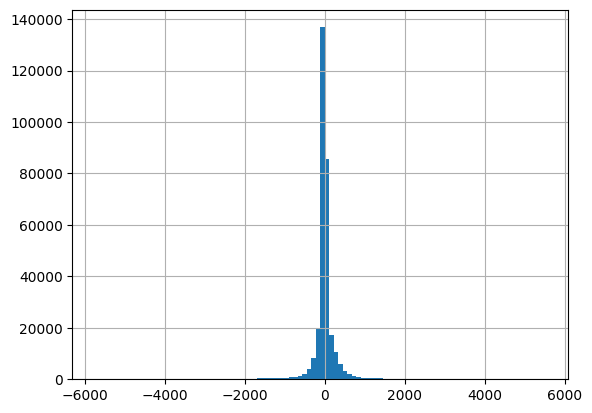

In [117]:
testDf.absErr_cons.hist(bins=100)

<Axes: >

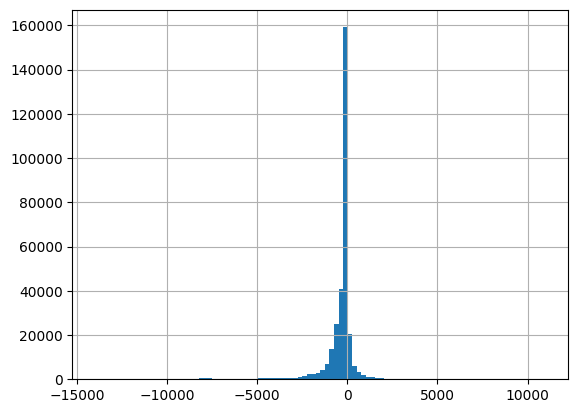

In [118]:
testDf.absErr_prod.hist(bins=100)

#### train

<Axes: xlabel='weekday'>

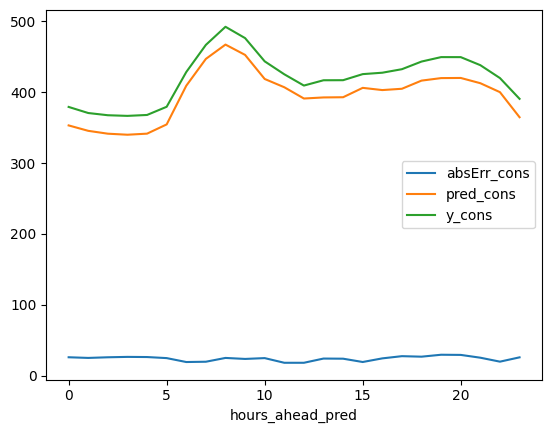

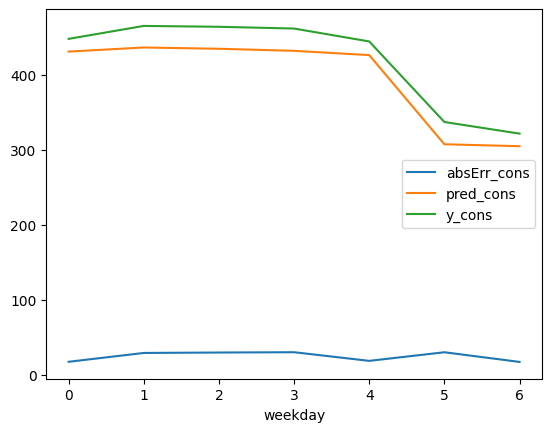

In [119]:
trainDf.groupby('hours_ahead_pred')[['absErr_cons','pred_cons','y_cons']].mean().plot()
trainDf.groupby('weekday')[['absErr_cons','pred_cons','y_cons']].mean().plot()

<Axes: xlabel='unique_time'>

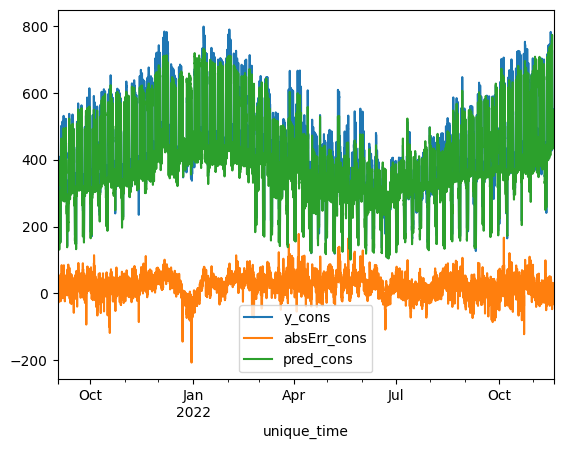

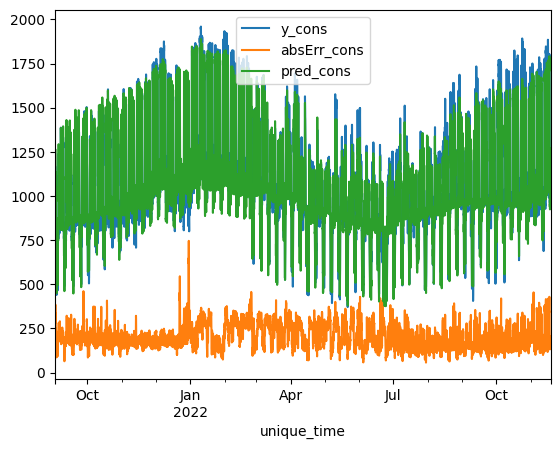

In [120]:
trainDf.groupby('unique_time')[['y_cons','absErr_cons','pred_cons']].mean().plot()
trainDf.groupby('unique_time')[['y_cons','absErr_cons','pred_cons']].std().plot()

### test

<Axes: xlabel='weekday'>

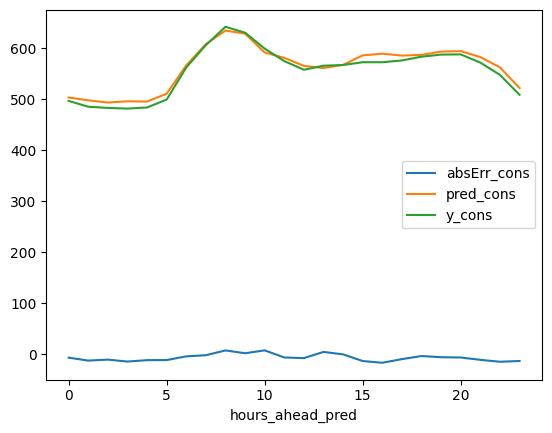

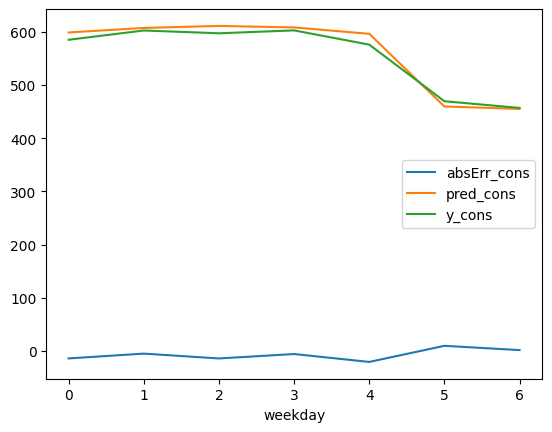

In [121]:
testDf.groupby('hours_ahead_pred')[['absErr_cons','pred_cons','y_cons']].mean().plot()
testDf.groupby('weekday')[['absErr_cons','pred_cons','y_cons']].mean().plot()

<Axes: xlabel='unique_time'>

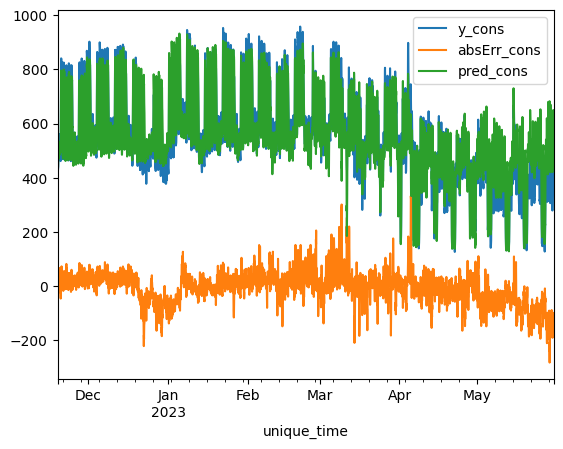

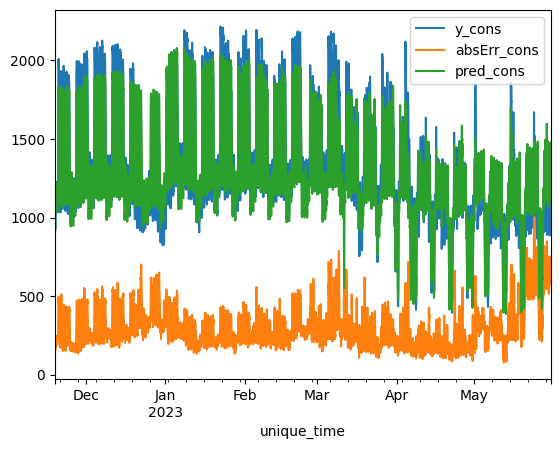

In [122]:
# notice that feb-may in 2023 are way different predictions
testDf.groupby('unique_time')[['y_cons','absErr_cons','pred_cons']].mean().plot()
testDf.groupby('unique_time')[['y_cons','absErr_cons','pred_cons']].std().plot()

In [ ]:
testDf.loc[testDf.absErr_cons > 1300].data_block_id.value_counts()

In [ ]:
pd.set_option('Display.max_columns',None)
testDf.loc[(testDf.data_block_id == 463) & (testDf.prediction_unit_id == 5)]#.sort_values(by='absErr_cons')

In [ ]:
testDf.loc[(testDf.data_block_id == 463) & (testDf.hours_ahead == 1)].sort_values(by='absErr_cons')

In [ ]:
testDf.loc[testDf.ePrices > 1000].unique_time.value_counts()

In [ ]:
testDf['normCons'] = testDf['y_cons'] / testDf['windspeed_10mint']
testDf['normConsProd'] = testDf['pred_cons'] / testDf['installed_capacity']
testDf = testDf.sort_values(by='unique_time')
a = testDf.loc[(testDf.month == 8)]

fig = subplots.make_subplots(rows=1, cols=1,shared_xaxes=True)

fig.add_trace(go.Scatter(x = a['unique_time'], y = a['y_cons'],mode ='markers', name='y_cons'),row=1, col=1)
fig.add_trace(go.Scatter(x = a['unique_time'], y = a['pred_cons'],mode ='markers', name='pred_cons'),row=1, col=1)
#fig.add_trace(go.Scatter(x = a['unique_time'], y = a['normCons'],mode ='markers', name='normCons'),row=1, col=1)
#fig.add_trace(go.Scatter(x = a['unique_time'], y = a['normConsProd'],mode ='markers', name='normConsProd'),row=1, col=1)
fig.show()

### check individual day difference
maybe some features corrupt result, seems that predictions are sometimes far off
features that are iffy: eic_count, ind_customer_id, prediction_unit_id, year

In [ ]:

f = ['y_cons','pred_cons','absErr_cons','county',
 'is_business',
 'product_type',

 'installed_capacity',
 'business_prodType',
 #'lowest_price_per_mwh',
 #'highest_price_per_mwh',
 #'yearday',
 #'weekday',
 #'month',
 #'monthday'
 ]
a = testDf.loc[(testDf.month == 8) & (testDf.monthday == 3) & (testDf.hours_ahead == 25)][f]

In [ ]:
b = testDf.loc[(testDf.month == 3) & (testDf.monthday == 3) & (testDf.hours_ahead == 25)][f]

In [ ]:
pd.set_option('Display.max_columns', None)
pd.set_option('Display.max_rows', None)
c = pd.merge(a,b,on=['county','is_business','product_type','business_prodType'], suffixes=('_a','_b'),how='outer')
sorted_columns = sorted(c.columns)
c = c[sorted_columns]
c
#features that are iffy: eic_count, ind_customer_id, prediction_unit_id, year

In [ ]:
pd.set_option('Display.max_columns', 10)
pd.set_option('Display.max_rows', 10)